<img src='../frameworks/img/EU-Copernicus-EUM-WEKEO_banner_logo.png' align='right' width='75%'></img>

<a href="../Index.ipynb"><< Index</a>
<br>
<a href="./1_5_OLCI_radiance_reflectance_spectra.ipynb"><< OLCI radiance and reflectance spectra</a>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<a href="1_7_OLCI_light_environment.ipynb">Assessing the light environment >></a>

Copernicus Marine Training Service <br>
**Copyright:** 2022 EUMETSAT <br>
**License:** MIT

<html>
  <div style="width:100%">
    <div style="float:left"><a href="https://trainhub.eumetsat.int/ocean/sensors/1_6_OLCI_CHL_comparison.ipynb"><img src="https://img.shields.io/badge/Launch-TrainHub-Blue.svg" alt="Open in TrainHub"></a></div>
    <div style="float:left"><p>&emsp;</p></div>
    <div style="float:left"><a href="https://mybinder.org/v2/gl/eumetlab%2Focean%2Fsensors%2Flearn-olci/main?labpath=1_OLCI_introductory/1_6_OLCI_CHL_comparison.ipynb"><img src="https://mybinder.org/badge_logo.svg" alt="Open in Binder"></a></div>
    <div style="float:left"><p>&emsp;</p></div>
    <div style="float:left"><a href="https://colab.research.google.com/github/eumetlab/ocean/sensors/learn-olci/blob/main/1_OLCI_introductory/1_6_OLCI_CHL_comparison.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab" /></a></div>
    <div style="float:left"><p>&emsp;</p></div>
    <div style="float:left"><a href="https://studiolab.sagemaker.aws/import/github/eumetlab/ocean/sensors/learn-olci/blob/main/1_OLCI_introductory/1_6_OLCI_CHL_comparison.ipynb"><img src="https://studiolab.sagemaker.aws/studiolab.svg" alt="Open In Studio Lab"/></a></div>
    <div style="float:left"><p>&emsp;</p></div>
    <div style="float:left"><a href="https://pccompute.westeurope.cloudapp.azure.com/compute/hub/user-redirect/git-pull?repo=https://github.com/eumetlab/ocean/sensors/learn-olci&urlpath=1_OLCI_introductory/1_6_OLCI_CHL_comparison.ipynb&branch=main"><img src="https://img.shields.io/badge/Open-Planetary%20Computer-black?style=flat&logo=microsoft" alt="Open in Planetary Computer"/></a></div>
  </div>
</html>

<div class="alert alert-block alert-success">
<h3>Learn OLCI: Introductory</h3></div>

<div class="alert alert-block alert-warning">
    
<b>PREREQUISITES </b>
    
The following modules are prerequisites for this notebook:
- **[1_1_OLCI_data_access.ipynb](1_1_OLCI_data_access.ipynb)** (this will download the required OLCI products for this notebook)

</div>
<hr>

# 1.6 Comparing OLCI chlorophyll products


### Data used

| Product Description  | Data Store collection ID|  WEkEO HDA ID | Product Navigator |
|:--------------------:|:-----------------------:|:-------------:|:-----------------:|
| Sentinel-3 OLCI level-2 full resolution  | EO:EUM:DAT:0407 | EO:EUM:DAT:SENTINEL-3:OL_2_WFR___ | [link](https://navigator.eumetsat.int/product/EO:EUM:DAT:SENTINEL-3:OL_2_WFR___NTC?query=OLCI&filter=satellite__Sentinel-3&filter=instrument__OLCI&filter=processingLevel__Level%202%20Data&s=advanced) |

### Learning outcomes

At the end of this notebook you will know;
* Objective


### Outline

<div class="alert alert-info" role="alert">

## <a id='TOC_TOP'></a>Contents

</div>
    
 1. [OLCI Chlorophyll products and algorithms](#section1)
 1. [Reading OLCI chlorophyll data](#section2)
 1. [Understanding and applying flags](#section3)
 1. [Plotting and comparing chlorophyll](#section4)

<hr>

In [1]:
import cartopy.crs as ccrs
import eumartools
import glob
import inspect
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import os
import warnings
import xarray as xr

warnings.filterwarnings('ignore')

<div class="alert alert-info" role="alert">

## <a id='section1'></a>1. OLCI Chlorophyll products and algorithms
[Back to top](#TOC_TOP)

</div>

blurb

<div class="alert alert-info" role="alert">

## <a id='section2'></a>2. Reading OLCI chlorophyll data
[Back to top](#TOC_TOP)

</div>

In [2]:
SAFE_directory = os.path.join(os.getcwd(), 'products',
    'S3A_OL_2_WFR____20210717T101015_20210717T101315_20210718T221347_0179_074_122_1980_MAR_O_NT_003.SEN3')

In [3]:
grid_reduce = 5

In [4]:
geo_file = os.path.join(SAFE_directory,'geo_coordinates.nc')
geo_fid = xr.open_dataset(geo_file)
lon = geo_fid.longitude.data[::grid_reduce, ::grid_reduce]
lat = geo_fid.latitude.data[::grid_reduce, ::grid_reduce]
geo_fid.close()

In [5]:
band_vars = xr.open_mfdataset(glob.glob(os.path.join(SAFE_directory,'chl*.nc')))
band_vars["CHL_ANOM"] = 10**band_vars['CHL_OC4ME'] - 10**band_vars['CHL_NN']
band_vars.close()

<div class="alert alert-info" role="alert">

## <a id='section3'></a>3. Understanding and applying flags
[Back to top](#TOC_TOP)

</div>

In [6]:
flag_file = os.path.join(SAFE_directory,'wqsf.nc')
flag_vars = xr.open_dataset(flag_file)
flag_vars.close()
band_vars["WQSF"] = flag_vars["WQSF"]

ii = np.argsort(flag_vars["WQSF"].flag_masks)
bitvals = np.array(flag_vars["WQSF"].flag_masks)[ii]
meanings = np.array(flag_vars["WQSF"].flag_meanings.split(' '))[ii]

print("Bit   Bitval                 BitMeaning")
for bitval, meaning, bit in zip(bitvals, meanings, np.arange(len(bitvals))):
    print(f"{str(bit).zfill(2)}    {str(bitval).zfill(20)}   {meaning}")

Bit   Bitval                 BitMeaning
00    00000000000000000001   INVALID
01    00000000000000000002   WATER
02    00000000000000000004   LAND
03    00000000000000000008   CLOUD
04    00000000000000000016   SNOW_ICE
05    00000000000000000032   INLAND_WATER
06    00000000000000000064   COASTLINE
07    00000000000000000128   TIDAL
08    00000000000000000256   COSMETIC
09    00000000000000000512   SUSPECT
10    00000000000000001024   HISOLZEN
11    00000000000000002048   SATURATED
12    00000000000000004096   MEGLINT
13    00000000000000008192   HIGHGLINT
14    00000000000000016384   WHITECAPS
15    00000000000000032768   ADJAC
16    00000000000000065536   WV_FAIL
17    00000000000000131072   PAR_FAIL
18    00000000000000262144   AC_FAIL
19    00000000000000524288   OC4ME_FAIL
20    00000000000001048576   OCNN_FAIL
21    00000000000002097152   KDM_FAIL
22    00000000000004194304   TURBID_ATM
23    00000000000008388608   CLOUD_AMBIGUOUS
24    00000000000016777216   CLOUD_MARGIN
25    0

In [7]:
# reading masks: example land
land_mask = eumartools.flag_mask(flag_file, 'WQSF', ['LAND'])
land_mask = land_mask.astype(float)[::grid_reduce, ::grid_reduce]
land_mask[land_mask == 0.0] = np.nan

In [8]:
# reading masks: example cloud
cloud_mask = eumartools.flag_mask(flag_file, 'WQSF', ['CLOUD', 'CLOUD_AMBIGUOUS', 'CLOUD_MARGIN'])
cloud_mask = cloud_mask.astype(float)[::grid_reduce, ::grid_reduce]
cloud_mask[cloud_mask == 0.0] = np.nan

In [9]:
# reading masks: example BAC recommended
all_mask = eumartools.flag_mask(flag_file, 'WQSF', ['LAND', 'CLOUD', 'CLOUD_AMBIGUOUS', 'CLOUD_MARGIN', 
                                                    'INVALID', 'COSMETIC', 'SATURATED', 'SUSPECT',
                                                    'HISOLZEN', 'HIGHGLINT', 'SNOW_ICE', 'AC_FAIL',
                                                    'WHITECAPS', 'ANNOT_ABSO_D', 'ANNOT_MIXR1',
                                                    'ANNOT_DROUT', 'ANNOT_TAU06', 'RWNEG_O2', 'RWNEG_O3',
                                                    'RWNEG_O4', 'RWNEG_O5', 'RWNEG_O6', 'RWNEG_O7', 'RWNEG_O8'])
all_mask = all_mask.astype(float)[::grid_reduce, ::grid_reduce]
all_mask[all_mask == 0.0] = np.nan

<div class="alert alert-info" role="alert">

## <a id='section4'></a>4. Plotting and comparing chlorophyll
[Back to top](#TOC_TOP)

</div>

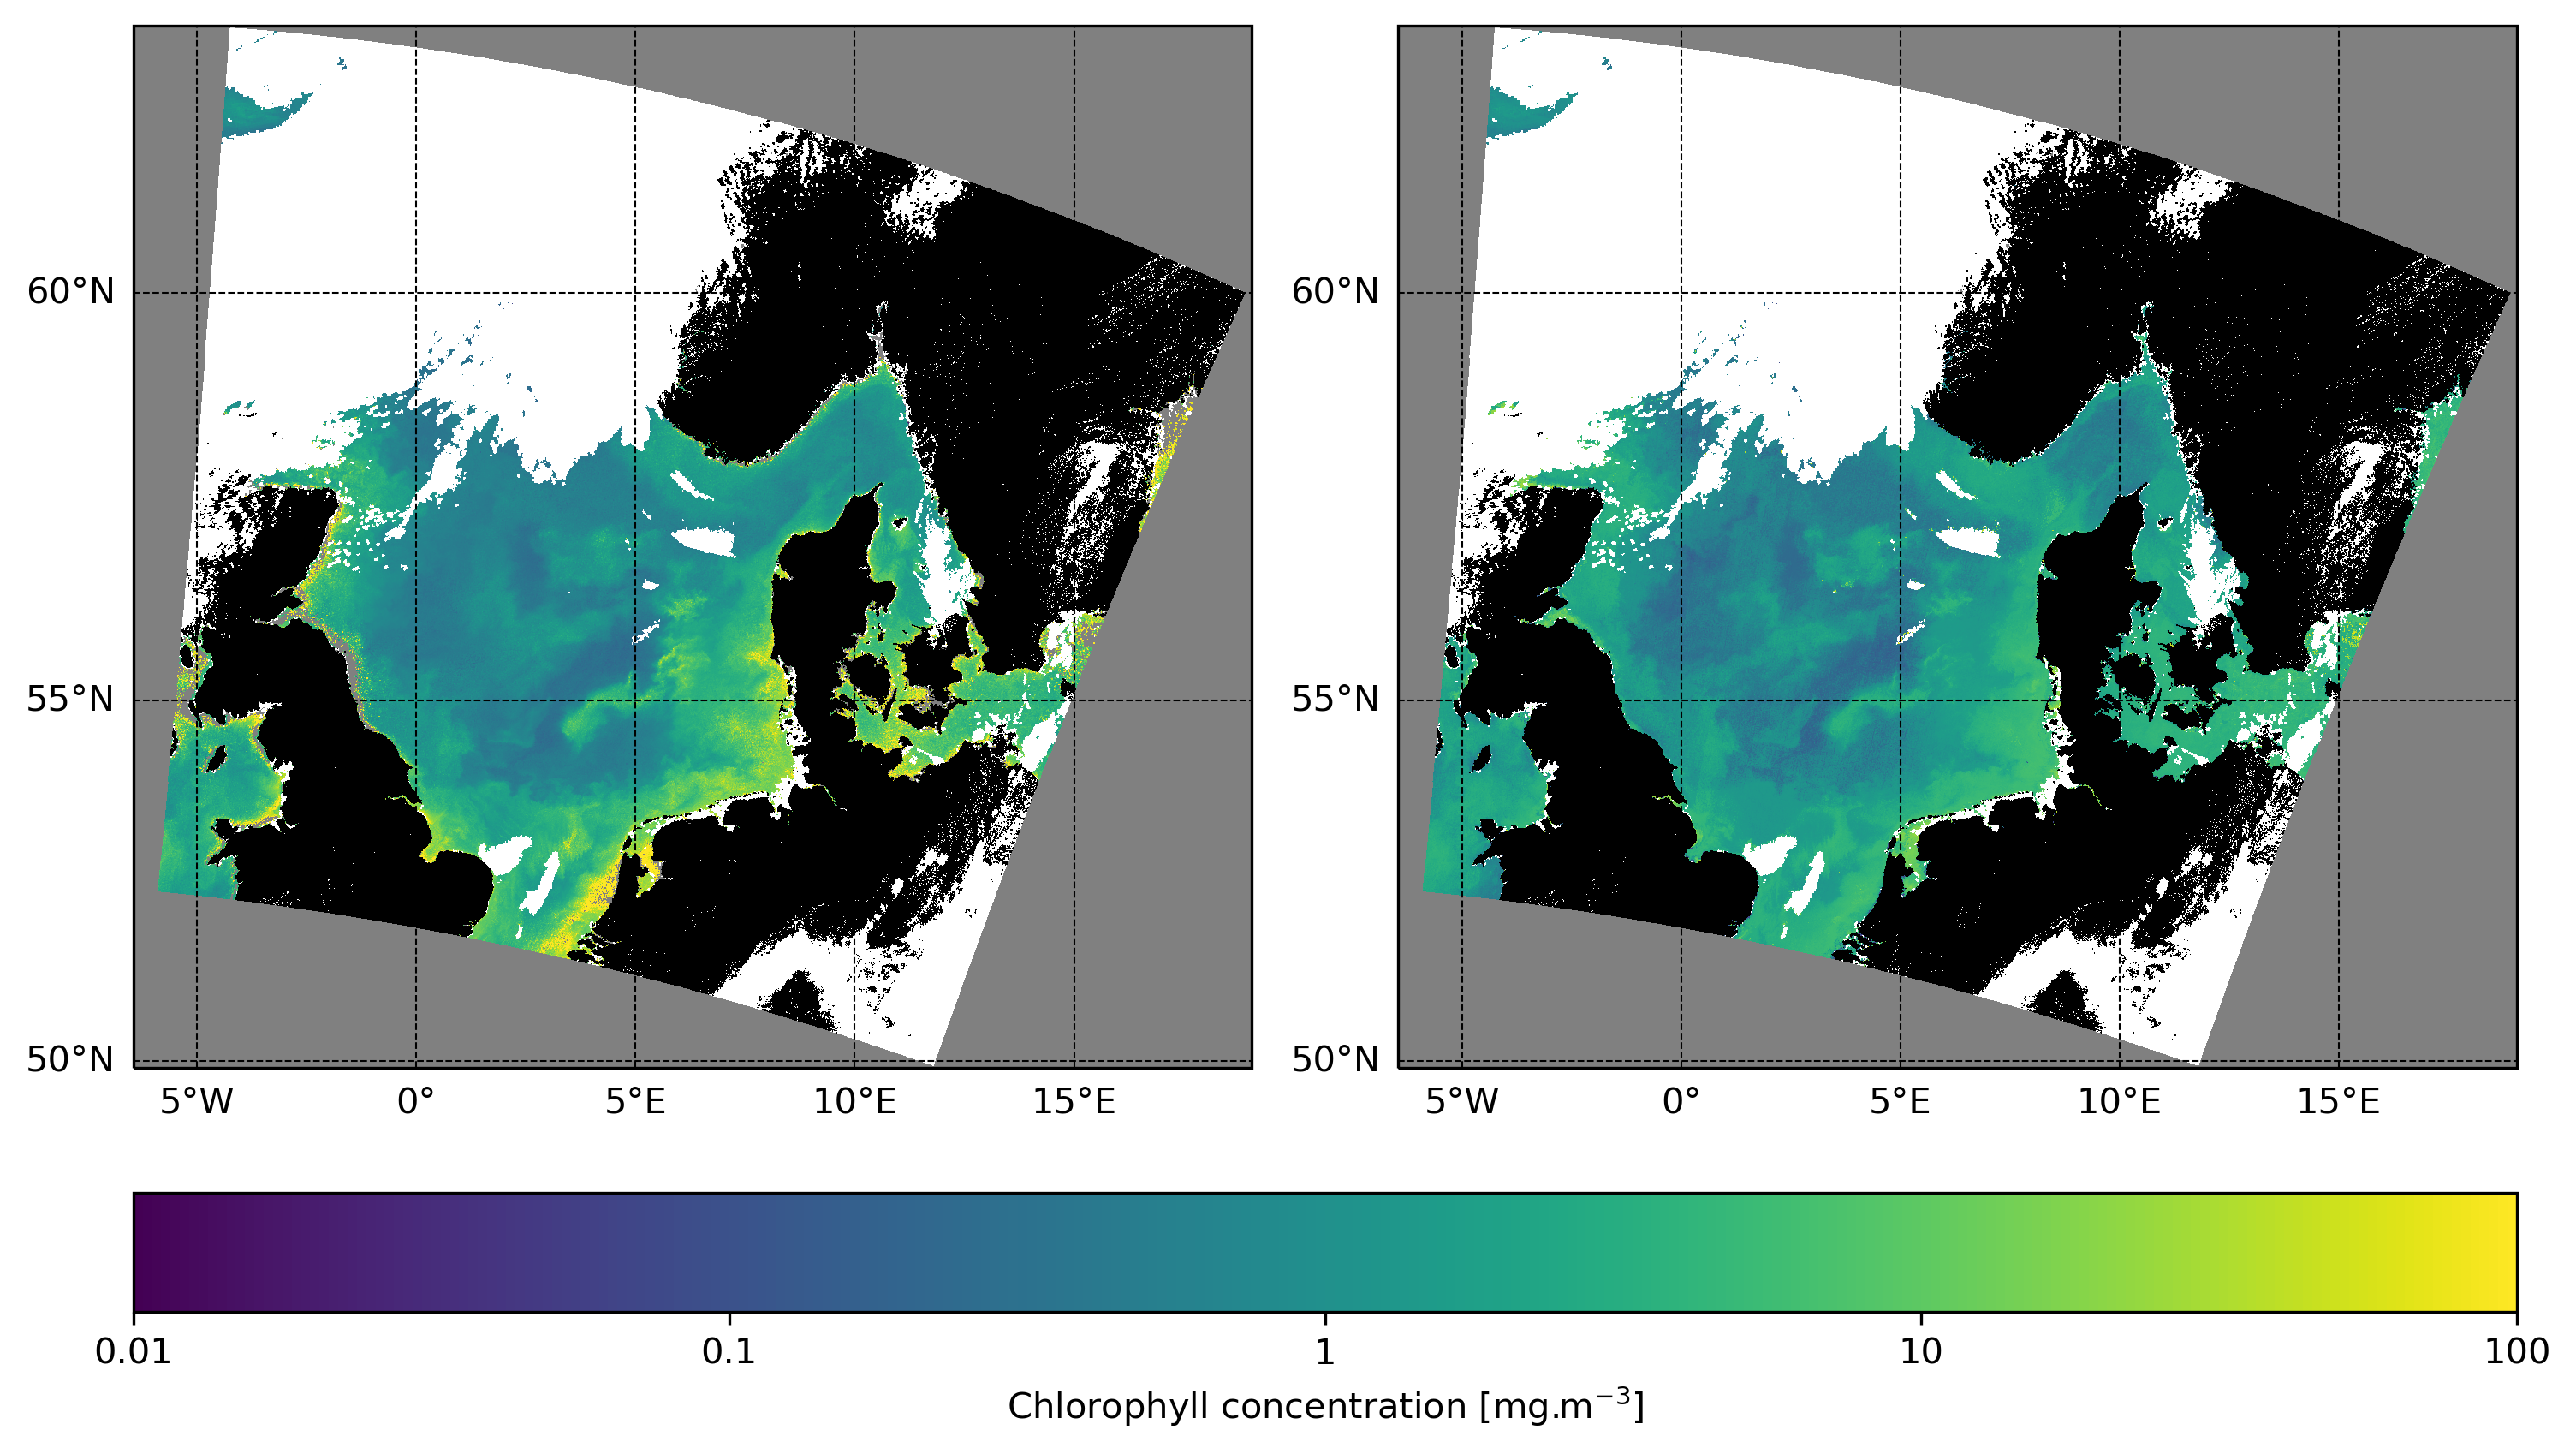

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(10, 10), dpi=300, subplot_kw={"projection": ccrs.Mercator()})

for ax, var, cmap in zip(axs.reshape(-1),
                         ['CHL_OC4ME', 'CHL_NN', 'CHL_ANOM'],
                         ['viridis','viridis',plt.cm.RdYlBu_r]):
    
    p1 = ax.pcolormesh(lon, lat, band_vars[var][::grid_reduce, ::grid_reduce], transform=ccrs.PlateCarree(), 
                       cmap=cmap, vmin=-2, vmax=2)
    ax.pcolormesh(lon, lat, cloud_mask, transform=ccrs.PlateCarree(), cmap=plt.cm.Greys)
    ax.pcolormesh(lon, lat, land_mask, transform=ccrs.PlateCarree(), cmap=plt.cm.Greys_r)

    # Embellish with gridlines
    g1 = ax.gridlines(draw_labels = True, zorder=20, color='0.0', linestyle='--',linewidth=0.5)
    g1.xlocator = mticker.FixedLocator(np.arange(-180, 180, 5))
    g1.ylocator = mticker.FixedLocator(np.arange(-90, 90, 5))
    g1.top_labels = False
    g1.right_labels = False
    g1.xlabel_style = {'size': 10, 'color': 'black'}
    g1.ylabel_style = {'size': 10, 'color': 'black'}
    ax.set(facecolor = "0.5")

plt.tight_layout()

cbar = fig.colorbar(p1, ax=[axs[:]], location='bottom', label='Chlorophyll concentration [mg.m$^{-3}$]', pad=0.05)
ticks = [-2,-1,0,1,2]
cbar.set_ticks(ticks)
cbar.set_ticklabels([10**tick for tick in ticks])

plt.savefig('../img/1_6_OLCI_CHL.png', bbox_inches='tight')

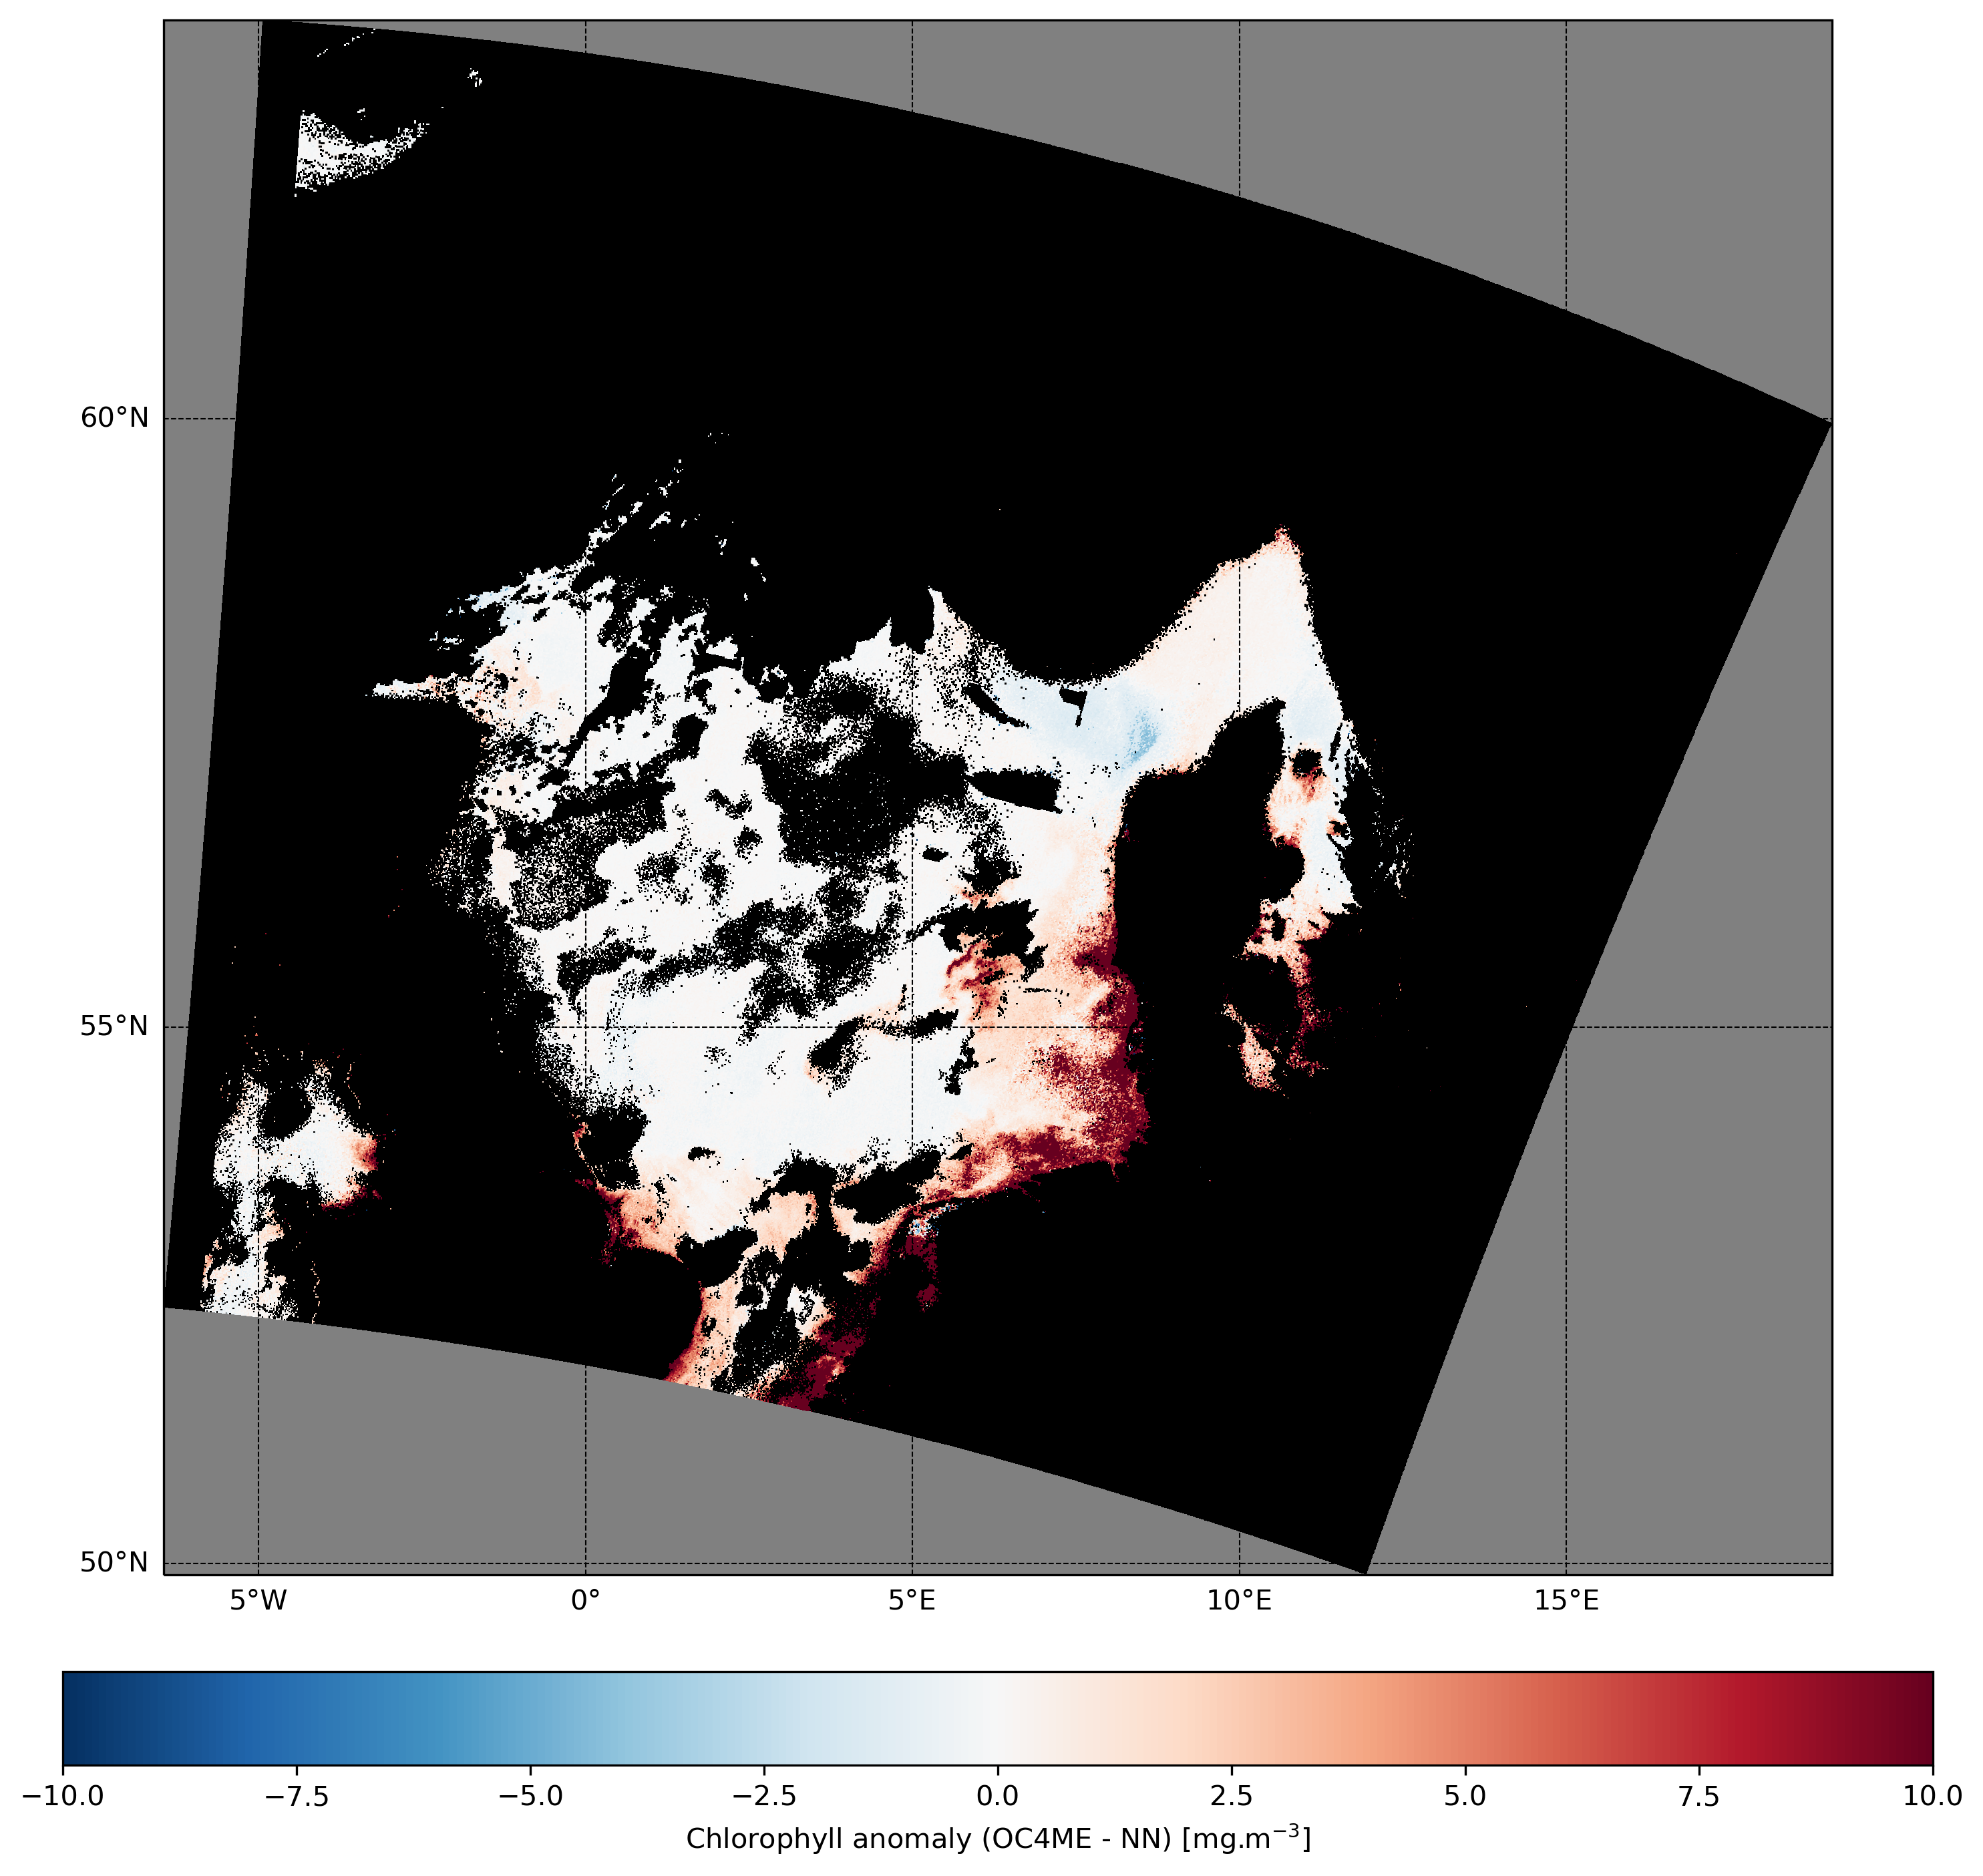

In [11]:
fig = plt.figure(figsize=(10, 10), dpi=300)
m = plt.subplot(projection=ccrs.Mercator())

p1 = m.pcolormesh(lon, lat, band_vars["CHL_ANOM"][::grid_reduce, ::grid_reduce], transform=ccrs.PlateCarree(), 
                   cmap=plt.cm.RdBu_r, vmin=-10, vmax=10)
m.pcolormesh(lon, lat, all_mask, transform=ccrs.PlateCarree(), cmap=plt.cm.Greys_r)

# Embellish with gridlines
g1 = m.gridlines(draw_labels = True, zorder=20, color='0.0', linestyle='--',linewidth=0.5)
g1.xlocator = mticker.FixedLocator(np.arange(-180, 180, 5))
g1.ylocator = mticker.FixedLocator(np.arange(-90, 90, 5))
g1.top_labels = False
g1.right_labels = False
g1.xlabel_style = {'size': 10, 'color': 'black'}
g1.ylabel_style = {'size': 10, 'color': 'black'}
m.set(facecolor = "0.5")

fig.colorbar(p1, location='bottom', label='Chlorophyll anomaly (OC4ME - NN) [mg.m$^{-3}$]', pad=0.05)
plt.tight_layout()

<hr>
<a href="https://gitlab.eumetsat.int/eumetlab/ocean/">View on GitLab</a> | <a href="https://training.eumetsat.int/">EUMETSAT Training</a> | <a href=mailto:ops@eumetsat.int>Contact helpdesk for support </a> | <a href=mailto:Copernicus.training@eumetsat.int>Contact our training team to collaborate on and reuse this material</a></span></p>